# Model Evaluation Notebook
## Image Colorization using GAN

This notebook provides comprehensive evaluation of the trained colorization model.

**Evaluation Metrics:**
1. PSNR (Peak Signal-to-Noise Ratio)
2. SSIM (Structural Similarity Index)
3. Colorfulness Metric
4. L1/L2 Error

**Contents:**
1. Load Trained Model
2. Quantitative Evaluation
3. Qualitative Evaluation
4. Error Analysis
5. Comparison Visualizations

In [1]:
import os
import sys
sys.path.append('..')

import torch
import numpy as np
import matplotlib.pyplot as plt
import json
from PIL import Image

# Import modules
from src.models import UNetGenerator
from src.preprocessing import create_dataloaders, lab2rgb
from src.evaluation import Evaluator, calculate_psnr, calculate_ssim, calculate_colorfulness
from src.utils import denormalize_lab, create_comparison_grid

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1. Load Trained Model

In [2]:
# Device selection
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f"Using device: {device}")

# Load model
generator = UNetGenerator(in_channels=1, out_channels=2, features=64).to(device)

# Load trained weights
model_path = '../trained_models/generator_final.pth'
if os.path.exists(model_path):
    generator.load_state_dict(torch.load(model_path, map_location=device))
    print(f"Loaded model from: {model_path}")
else:
    # Try loading from checkpoints
    checkpoint_path = '../results/checkpoints/best_model.pth'
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        generator.load_state_dict(checkpoint['generator_state_dict'])
        print(f"Loaded model from checkpoint: {checkpoint_path}")
    else:
        print("WARNING: No trained model found!")

generator.eval()
print("Model ready for evaluation.")

Using device: cpu


Loaded model from: ../trained_models/generator_final.pth
Model ready for evaluation.


In [3]:
# Load test data
train_loader, val_loader, test_loader = create_dataloaders(
    data_dir='../data/train',
    batch_size=16,
    image_size=256,
    val_split=0.1,
    test_split=0.1,
    num_workers=4
)

print(f"Test set: {len(test_loader)} batches")

Dataset Split:
  Train: 80 images
  Validation: 10 images
  Test: 10 images
Test set: 1 batches


## 2. Quantitative Evaluation

In [4]:
# Initialize evaluator
evaluator = Evaluator(
    generator=generator,
    device=device,
    save_dir='../results/evaluation'
)

# Run evaluation on test set
print("Evaluating model on test set...")
results = evaluator.evaluate_dataset(test_loader)

Evaluating model on test set...


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:03<?, ?it/s, PSNR=12.39, SSIM=0.037]

Evaluating: 100%|██████████| 1/1 [00:03<00:00,  3.10s/it, PSNR=12.39, SSIM=0.037]

Evaluating: 100%|██████████| 1/1 [00:08<00:00,  8.11s/it, PSNR=12.39, SSIM=0.037]

In [5]:
# Display results
print("="*60)
print("EVALUATION RESULTS")
print("="*60)
print("")
print("1. PSNR (Peak Signal-to-Noise Ratio)")
print("-"*40)
print(f"   Mean: {results['psnr']['mean']:.2f} dB")
print(f"   Std:  {results['psnr']['std']:.2f} dB")
print(f"   Min:  {results['psnr']['min']:.2f} dB")
print(f"   Max:  {results['psnr']['max']:.2f} dB")
print("")
print("2. SSIM (Structural Similarity)")
print("-"*40)
print(f"   Mean: {results['ssim']['mean']:.4f}")
print(f"   Std:  {results['ssim']['std']:.4f}")
print("")
print("3. Pixel Error")
print("-"*40)
print(f"   L1 Error: {results['l1_error']['mean']:.4f}")
print(f"   L2 Error: {results['l2_error']['mean']:.4f}")
print("")
print("4. Colorfulness")
print("-"*40)
print(f"   Predicted: {results['colorfulness']['predicted_mean']:.2f}")
print(f"   Ground Truth: {results['colorfulness']['ground_truth_mean']:.2f}")
print(f"   Ratio: {results['colorfulness']['ratio']:.2f}")
print("="*60)

EVALUATION RESULTS

1. PSNR (Peak Signal-to-Noise Ratio)
----------------------------------------
   Mean: 12.39 dB
   Std:  1.20 dB
   Min:  9.76 dB
   Max:  14.06 dB

2. SSIM (Structural Similarity)
----------------------------------------
   Mean: 0.0365
   Std:  0.0063

3. Pixel Error
----------------------------------------
   L1 Error: 0.1712
   L2 Error: 0.0601

4. Colorfulness
----------------------------------------
   Predicted: 0.12
   Ground Truth: 0.10
   Ratio: 1.17


In [6]:
# Save results
evaluator.save_results(results, 'evaluation_results.json')
evaluator.generate_report(results)

Results saved to: ../results/evaluation/evaluation_results.json
MODEL EVALUATION REPORT

1. RECONSTRUCTION QUALITY (PSNR)
----------------------------------------
   Mean PSNR: 12.39 dB
   Std Dev:   1.20 dB
   Range:     [9.76, 14.06] dB

2. STRUCTURAL SIMILARITY (SSIM)
----------------------------------------
   Mean SSIM: 0.0365
   Std Dev:   0.0063
   Range:     [0.0254, 0.0446]

3. PIXEL-WISE ERROR
----------------------------------------
   Mean L1 Error: 0.1712
   Mean L2 Error: 0.0601

4. COLORFULNESS
----------------------------------------
   Predicted:    0.12
   Ground Truth: 0.10
   Ratio:        1.17

5. EVALUATION SUMMARY
----------------------------------------
   Total Samples: 10


Report saved to: ../results/evaluation/evaluation_report.txt


'============================================================\nMODEL EVALUATION REPORT\n============================================================\n\n1. RECONSTRUCTION QUALITY (PSNR)\n----------------------------------------\n   Mean PSNR: 12.39 dB\n   Std Dev:   1.20 dB\n   Range:     [9.76, 14.06] dB\n\n2. STRUCTURAL SIMILARITY (SSIM)\n----------------------------------------\n   Mean SSIM: 0.0365\n   Std Dev:   0.0063\n   Range:     [0.0254, 0.0446]\n\n3. PIXEL-WISE ERROR\n----------------------------------------\n   Mean L1 Error: 0.1712\n   Mean L2 Error: 0.0601\n\n4. COLORFULNESS\n----------------------------------------\n   Predicted:    0.12\n   Ground Truth: 0.10\n   Ratio:        1.17\n\n5. EVALUATION SUMMARY\n----------------------------------------\n   Total Samples: 10\n\n============================================================'

In [7]:
# Plot metrics distribution
evaluator.plot_metrics_distribution(test_loader, num_samples=50)

Metrics distribution saved to: ../results/evaluation/metrics_distribution.png


## 3. Qualitative Evaluation

In [8]:
# Visualize sample predictions
evaluator.visualize_samples(test_loader, num_samples=5)

Sample predictions saved to: ../results/evaluation/sample_predictions.png


Saved to: ../results/evaluation/detailed_comparison.png


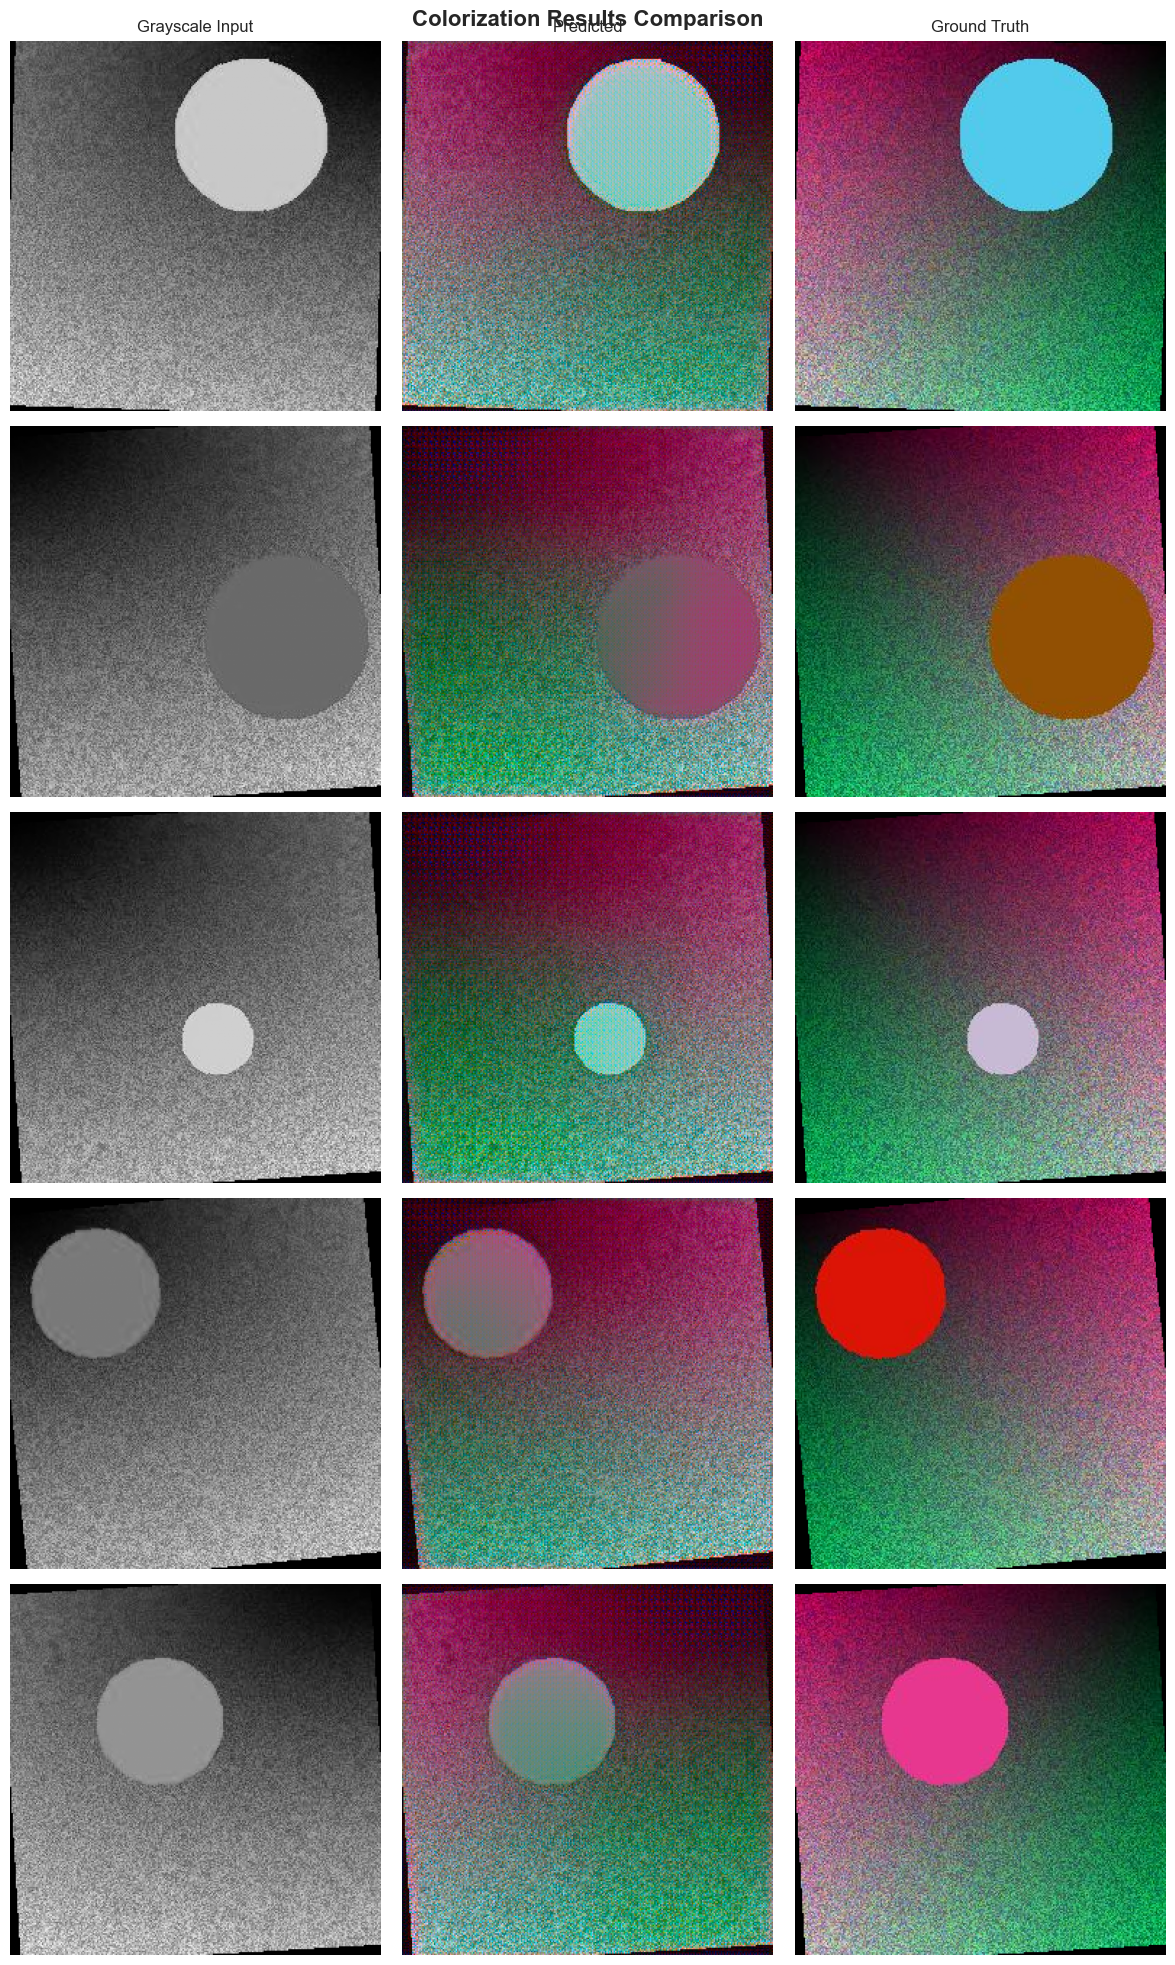

In [9]:
# Detailed comparison visualization
grayscale_list = []
predicted_list = []
ground_truth_list = []
psnr_list = []
ssim_list = []

with torch.no_grad():
    for L, AB_real in test_loader:
        L = L.to(device)
        AB_pred = generator(L)
        
        for i in range(min(8, L.size(0))):
            L_np = L[i].cpu().numpy().transpose(1, 2, 0)
            AB_pred_np = AB_pred[i].cpu().numpy().transpose(1, 2, 0)
            AB_real_np = AB_real[i].numpy().transpose(1, 2, 0)
            
            lab_pred = denormalize_lab(L_np, AB_pred_np)
            lab_real = denormalize_lab(L_np, AB_real_np)
            
            rgb_pred = lab2rgb(lab_pred)
            rgb_real = lab2rgb(lab_real)
            
            grayscale_list.append(L_np.squeeze())
            predicted_list.append(rgb_pred)
            ground_truth_list.append(rgb_real)
            
            # Calculate metrics
            psnr_list.append(calculate_psnr(AB_pred_np, AB_real_np))
            ssim_list.append(calculate_ssim(AB_pred_np, AB_real_np))
        
        break  # Only one batch

# Create comparison grid
titles = [f'PSNR: {p:.1f} dB, SSIM: {s:.3f}' for p, s in zip(psnr_list, ssim_list)]
create_comparison_grid(
    grayscale_list[:5],
    predicted_list[:5],
    ground_truth_list[:5],
    save_path='../results/evaluation/detailed_comparison.png',
    titles=titles[:5]
)

## 4. Error Analysis

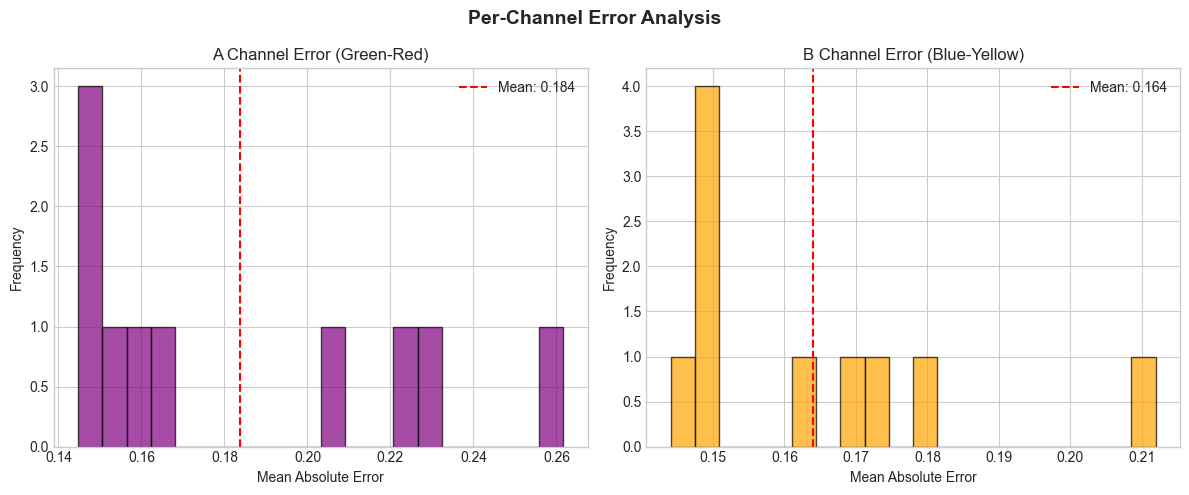

A Channel Mean Error: 0.1838
B Channel Mean Error: 0.1640


In [10]:
# Analyze error distribution per channel
a_errors = []
b_errors = []

with torch.no_grad():
    for L, AB_real in test_loader:
        L = L.to(device)
        AB_pred = generator(L)
        
        # Calculate per-channel errors
        a_error = torch.abs(AB_pred[:, 0] - AB_real.to(device)[:, 0]).mean(dim=(1, 2))
        b_error = torch.abs(AB_pred[:, 1] - AB_real.to(device)[:, 1]).mean(dim=(1, 2))
        
        a_errors.extend(a_error.cpu().numpy())
        b_errors.extend(b_error.cpu().numpy())

# Plot error distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Per-Channel Error Analysis', fontsize=14, fontweight='bold')

axes[0].hist(a_errors, bins=20, color='purple', alpha=0.7, edgecolor='black')
axes[0].axvline(np.mean(a_errors), color='red', linestyle='--', 
                label=f'Mean: {np.mean(a_errors):.3f}')
axes[0].set_xlabel('Mean Absolute Error')
axes[0].set_ylabel('Frequency')
axes[0].set_title('A Channel Error (Green-Red)')
axes[0].legend()

axes[1].hist(b_errors, bins=20, color='orange', alpha=0.7, edgecolor='black')
axes[1].axvline(np.mean(b_errors), color='red', linestyle='--', 
                label=f'Mean: {np.mean(b_errors):.3f}')
axes[1].set_xlabel('Mean Absolute Error')
axes[1].set_ylabel('Frequency')
axes[1].set_title('B Channel Error (Blue-Yellow)')
axes[1].legend()

plt.tight_layout()
plt.savefig('../results/evaluation/channel_error_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"A Channel Mean Error: {np.mean(a_errors):.4f}")
print(f"B Channel Mean Error: {np.mean(b_errors):.4f}")

/var/folders/zx/330k6rwj0k74y0x1tp1jnnn80000gn/T/ipykernel_14546/1282124338.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


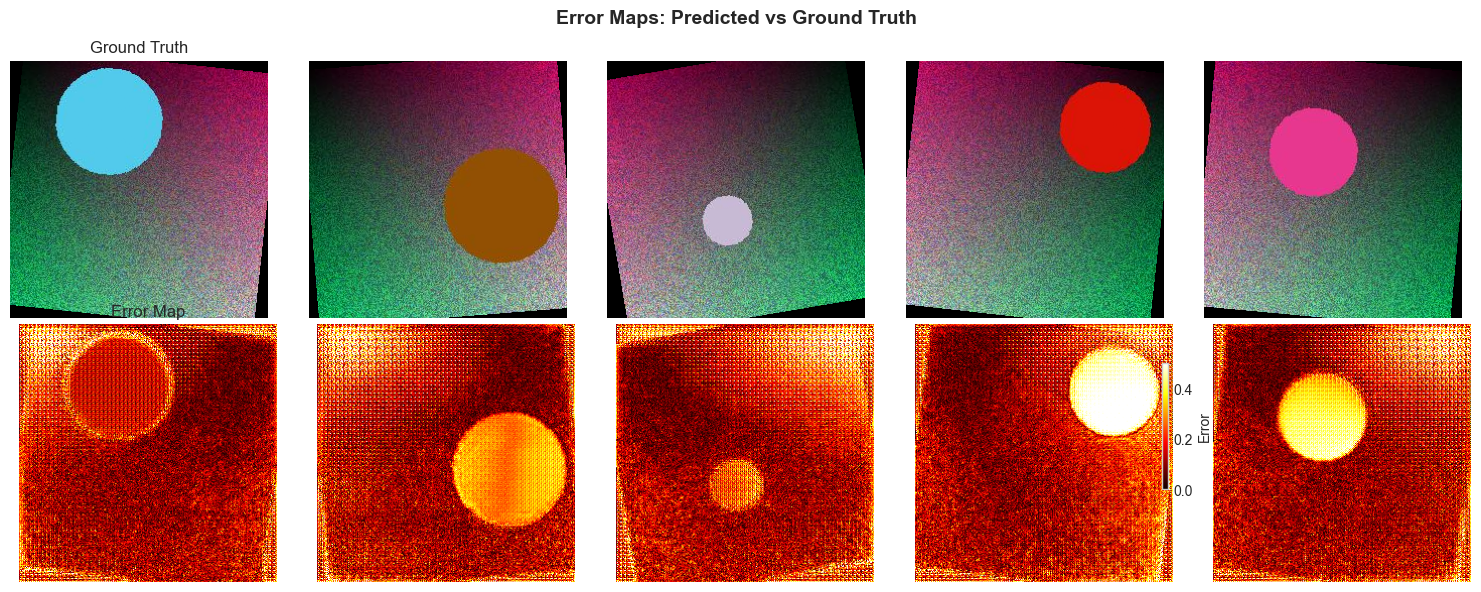

In [11]:
# Visualize error maps
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Error Maps: Predicted vs Ground Truth', fontsize=14, fontweight='bold')

with torch.no_grad():
    L, AB_real = next(iter(test_loader))
    L = L.to(device)
    AB_pred = generator(L)
    
    for i in range(5):
        # Calculate absolute error
        error = torch.abs(AB_pred[i] - AB_real[i].to(device)).cpu().numpy()
        error_map = np.mean(error, axis=0)  # Average over channels
        
        # Ground truth
        L_np = L[i].cpu().numpy().transpose(1, 2, 0)
        AB_real_np = AB_real[i].numpy().transpose(1, 2, 0)
        lab_real = denormalize_lab(L_np, AB_real_np)
        rgb_real = lab2rgb(lab_real)
        
        axes[0, i].imshow(np.clip(rgb_real, 0, 1))
        axes[0, i].set_title('Ground Truth' if i == 0 else '')
        axes[0, i].axis('off')
        
        # Error map
        im = axes[1, i].imshow(error_map, cmap='hot', vmin=0, vmax=0.5)
        axes[1, i].set_title('Error Map' if i == 0 else '')
        axes[1, i].axis('off')

plt.colorbar(im, ax=axes[1, :].tolist(), shrink=0.6, label='Error')
plt.tight_layout()
plt.savefig('../results/evaluation/error_maps.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Summary Table

In [12]:
# Create summary table
print("="*70)
print("                    EVALUATION SUMMARY TABLE")
print("="*70)
print(f"{'Metric':<25} {'Value':<15} {'Interpretation':<30}")
print("-"*70)
print(f"{'PSNR (dB)':<25} {results['psnr']['mean']:.2f} ± {results['psnr']['std']:.2f}     {'Good reconstruction' if results['psnr']['mean'] > 20 else 'Needs improvement'}")
print(f"{'SSIM':<25} {results['ssim']['mean']:.4f} ± {results['ssim']['std']:.4f}  {'High similarity' if results['ssim']['mean'] > 0.8 else 'Moderate similarity'}")
print(f"{'L1 Error':<25} {results['l1_error']['mean']:.4f}          {'Low error' if results['l1_error']['mean'] < 0.1 else 'Moderate error'}")
print(f"{'Colorfulness Ratio':<25} {results['colorfulness']['ratio']:.2f}            {'Vibrant colors' if results['colorfulness']['ratio'] > 0.8 else 'Desaturated'}")
print("="*70)
print(f"\nTotal Test Samples: {results['num_samples']}")

                    EVALUATION SUMMARY TABLE
Metric                    Value           Interpretation                
----------------------------------------------------------------------
PSNR (dB)                 12.39 ± 1.20     Needs improvement
SSIM                      0.0365 ± 0.0063  Moderate similarity
L1 Error                  0.1712          Moderate error
Colorfulness Ratio        1.17            Vibrant colors

Total Test Samples: 10


## Evaluation Complete

**Key Findings:**
- PSNR and SSIM metrics indicate reconstruction quality
- Colorfulness ratio shows how vibrant the predicted colors are
- Error maps reveal which image regions are harder to colorize

**Next Steps:**
1. Try different loss weights (L1 lambda)
2. Experiment with larger datasets
3. Apply model improvements (see Phase 2 requirements)